In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R


In [6]:
def convert_to_euler_angles(df):
    '''
    Converts the quaternions in the dataframe to euler angles
    '''
    df['theta'] = np.nan
    for i in range(len(df)):
       r = R.from_quat([df['qx'][i], df['qy'][i], df['qz'][i], df['qw'][i]])
       #df.loc[i, 'roll'], df.loc[i, 'pitch'], df.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       _,_, df.loc[i, 'theta'] = r.as_euler('xyz', degrees=True)
       
    return df

In [9]:
df = pd.read_csv('../Aufnahmen/data/odom.csv')
print(df.head())
df = convert_to_euler_angles(df)
df.drop(['z','qx', 'qy', 'qz', 'qw'], axis=1, inplace=True)
df.to_csv('../Aufnahmen/data/poses.csv', index=False)
df.head()


                     datetime         x         y    z   qx   qy        qz  \
0  2023-06-29 13:55:44.614539 -0.503331  0.912730  0.0  0.0  0.0  0.195900   
1  2023-06-29 13:55:44.639550 -0.484567  0.920539  0.0  0.0  0.0  0.203749   
2  2023-06-29 13:55:44.661994 -0.468499  0.927529  0.0  0.0  0.0  0.210507   
3  2023-06-29 13:55:44.679507 -0.455352  0.933466  0.0  0.0  0.0  0.216062   
4  2023-06-29 13:55:44.699996 -0.440248  0.940495  0.0  0.0  0.0  0.222506   

         qw  
0  0.980624  
1  0.979023  
2  0.977592  
3  0.976380  
4  0.974931  


,datetime,x,y,theta
0,2023-06-29 13:55:44.614539,-0.503331,0.912730,22.594556
1,2023-06-29 13:55:44.639550,-0.484567,0.920539,23.512605
2,2023-06-29 13:55:44.661994,-0.468499,0.927529,24.304094
3,2023-06-29 13:55:44.679507,-0.455352,0.933466,24.955724
4,2023-06-29 13:55:44.699996,-0.440248,0.940495,25.712518


In [48]:
#visualize the trajectory
plt.figure(figsize=(10,10))
nr_points = 70
# Add arrows to indicate the direction
for i in range(nr_points):
    dx = 0.003*np.cos(np.radians(df['yaw'][i]))  # calculate the change in x
    dy = 0.003*np.sin(np.radians(df['yaw'][i]))  # calculate the change in y
    plt.arrow(df['x'][i], df['y'][i], dx, dy, head_width=0.005, head_length=0.01, fc='blue', ec='blue')
plt.scatter(df['x'][:nr_points], df['y'][:nr_points],s=5, c='red')
plt.show()

KeyError: 'yaw'

<Figure size 1000x1000 with 0 Axes>

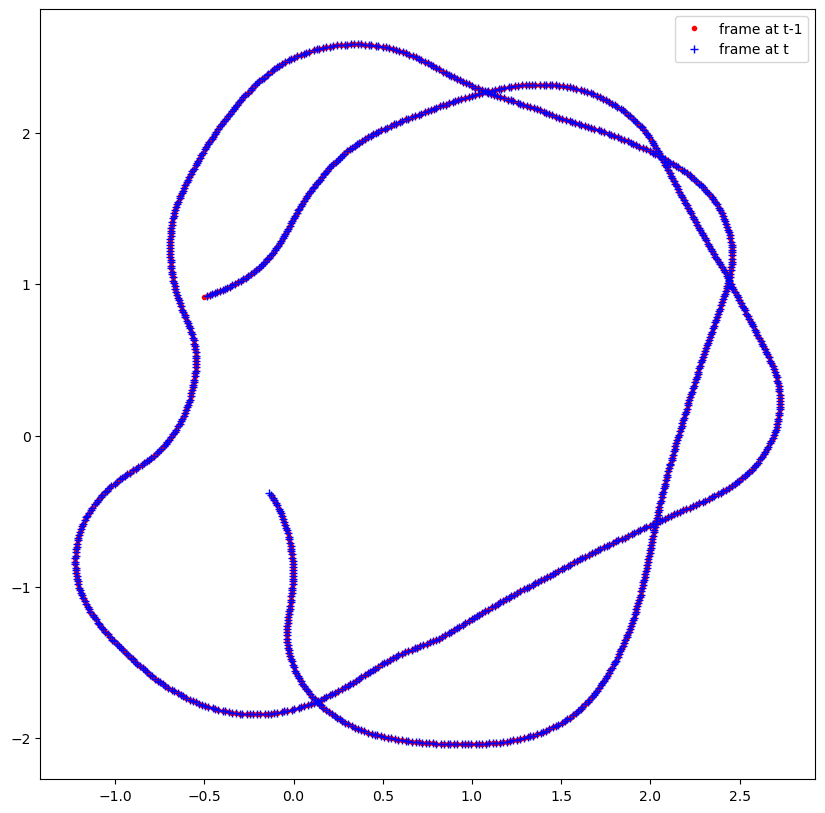

In [ ]:
#visualize the difference between x, y and x-1, y-1
#make new columns x-1 y-1
df['x-1'] = df['x'].shift(-1)
df['y-1'] = df['y'].shift(-1)
#plot first 100 x, y and x-1, y-1 as markers
nr_points = 1200
plt.figure(figsize=(10,10))
plt.plot(df['x'][:nr_points], df['y'][:nr_points], 'r.',label='frame at t-1')
plt.plot(df['x-1'][:nr_points], df['y-1'][:nr_points], 'b+',label='frame at t')
plt.legend()
plt.show()


In [ ]:
# from .vehicle_pose import pose
# pose = pose()
# #make dict with x,y,theta
# dict = {'x': 0, 'y': 0, 'theta': 0}
# for i in range(len(df)):
#     pose.update(df['x'][i], df['y'][i], df['yaw'][i])

In [63]:

# Load the data
df_curvature = pd.read_csv('../Aufnahmen/data/curvatures.csv')
df_curvature['index'] = df_curvature.index
df_offset = pd.read_csv('../Aufnahmen/data/offsets.csv')
df_offset['index'] = df_offset.index
#merge the dataframes
df = pd.merge(df_curvature, df_offset, on='index', how='inner')
df_high = pd.read_csv('../Aufnahmen/data/odom.csv')
df_heading = convert_to_euler_angles(df_high)
df_heading.to_csv('../Aufnahmen/data/heading_angles.csv')
df_heading.head()
# Calculate the ratio of the lengths
ratio = len(df_high) // len(df)
# print(ratio)

# # Create an index column
df['index'] = df.index
df_heading['index'] = df_heading.index // ratio

# # Downsample the high rate data
df_heading_downsampled = df_heading.groupby('index').first()

# # Merge the dataframes
df_combined = pd.merge(df, df_heading_downsampled, on='index', how='inner')
# #remove column 'index'
df_combined = df_combined.drop(columns=['index',])
df_combined.head()
# df_combined.tail()

,curvature,lateral_offset,heading_angle
0,-0.009975,20,22.594556
1,-0.010524,11,24.955724
2,-0.017683,-1,27.162433
3,-0.017250,-13,29.167563
4,-0.016694,-17,32.926399


In [62]:
#calculate derivative of curvature
dKdt = np.gradient(df_combined['curvature'],1/30)
df_combined['der_curvature'] = dKdt
#sort columns as lateral offset, heading angle, curvature, derivative of curvature
df_combined = df_combined[['lateral_offset', 'heading_angle', 'curvature', 'der_curvature']]
df_combined.head()
#to csv
df_combined.to_csv('../Aufnahmen/data/stateVars.csv', index=False)

In [6]:
import pandas as pd
from scipy.spatial.transform import Rotation as R
def convert_to_euler_angles(df):
    '''
    Converts the quaternions in the dataframe to euler angles
    '''
    df_ha = pd.DataFrame(columns=['heading_angle'])
    for i in range(len(df)):
       r = R.from_quat([df['qx'][i], df['qy'][i], df['qz'][i], df['qw'][i]])
       #df.loc[i, 'roll'], df.loc[i, 'pitch'], df.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       _,_, df_ha.loc[i, 'heading_angle'] = r.as_euler('xyz', degrees=True)
       
    return df_ha
df_odom = pd.read_csv('../Aufnahmen/data/odom.csv')
df_heading = convert_to_euler_angles(df_odom)
df_heading['datetime'] = df_odom['datetime']
df_heading['datetime'] = pd.to_datetime(df_heading['datetime'])
#make datetime column the index
df_heading = df_heading.set_index('datetime')
df_heading.head()
print('max min heading angle: ', df_heading['heading_angle'].max(), df_heading['heading_angle'].min())
#df_heading.to_csv('../Aufnahmen/data/heading_angles.csv')

max min heading angle:  179.9811204165528 -179.99866744669612


In [31]:
import pandas as pd
import numpy as np
df_measurements = pd.read_csv('../Aufnahmen/data/frame_measurements.csv')
df_measurements['datetime'] = pd.to_datetime(df_measurements['datetime'])
print(df_measurements.head())
df_heading['datetime'] = pd.to_datetime(df_heading['datetime'])
df = pd.merge_asof(df_measurements, df_heading, on='datetime', direction='nearest')
df.head()
df_ackermann = pd.read_csv('../Aufnahmen/data/ackermann.csv')
df_ackermann['datetime'] = pd.to_datetime(df_ackermann['datetime'])
df = pd.merge_asof(df, df_ackermann, on='datetime', direction='nearest')
#calculate average time between measurements
avg_time = np.mean(np.diff(df['datetime']))
#convert to seconds
avg_time = avg_time / np.timedelta64(1, 's')
#calculate derivative of curvature
# dKdt = np.gradient(df['curvature'],np.diff(df['datetime']))
# df['der_curvature'] = dKdt
#sort columns as datetime, lateral offset, heading angle, curvature, derivative of curvature, speed, steering angle
df = df[['datetime', 'lateral_offset', 'heading_angle', 'curvature', 'speed', 'steering_angle']]

df.to_csv('../Aufnahmen/data/kalmanVars.csv', index=True)
df.head()

   curvature                   datetime  lateral_offset
0  -0.009975 2023-06-29 13:55:44.785644              20
1  -0.010524 2023-06-29 13:55:44.875628              11
2  -0.010902 2023-06-29 13:55:44.965611               3
3  -0.017683 2023-06-29 13:55:44.993105              -1
4  -0.017250 2023-06-29 13:55:45.038097             -13


,datetime,lateral_offset,heading_angle,curvature,speed,steering_angle
0,2023-06-29 13:55:44.785644,20,29.167563,-0.009975,0.85,0.278034
1,2023-06-29 13:55:44.875628,11,34.666621,-0.010524,0.95,0.456348
2,2023-06-29 13:55:44.965611,3,41.767706,-0.010902,0.90,0.472000
3,2023-06-29 13:55:44.993105,-1,43.644168,-0.017683,0.90,0.472000
4,2023-06-29 13:55:45.038097,-13,46.826032,-0.017250,0.90,0.472000
